# MCT4052 Workshop 5a: Dimensionality Reduction Techniques

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

Dimensionality reduction techniques belong to unsupervised learning methods (with a few exceptions). They help to reduce the number of dimensions (or features) in a ML system (recall the curse of dimensionailty). Dimensionality reduction techniques are generally applied after computing (and eventually selecting/combining) and scaling features and training the ML model. It is "fair" to learn the dimensionality reduction transformation/projection only on the training data and then apply the transformation (often called projection) to the testing data as well (i.e. we split the data train/test before the dimensionality reduction part). When working with a large number of features, including a stage of dimensionality reduction is likely to improve performances.

This notebook applies and display the result fo three dimensionality reduction techniques: [Principal Component Analysis(PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [Linear Discriminant Analysis (LDA)](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html), and [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).

PCA and LDA are linear techniques. The transformation they apply is limited to orthoghonal axis rotation and shift (i.e. the overall shape of the data is preserved, we only change the "point of view"). Isomap is a non linear technique, and in this case transformation are more complex and are likely to result in a "modification" of the overall "shape" or "spatial distribution" of the data. However, Non linear techniques usually preserve the local/close neighborhoos relationships between samples (i.e. individual entries in the dataset), so examples that are close to each other in the high dimensional space, will be in close proximity also after the dimensionality reduction projection.

PCA belongs to the family of [decomposition techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis). Isomap belong to the family of [manifold learning techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold). These techniques are unsupervised, as labels associated to the data are not needed.

LDA belongs to the family of [discriminant analysis techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis) which also require to know the lables associated with the data (they look for a transformation what ease the task of separating/discriminating different classes). Discriminant analysis technique can significantly improve the performances of supervised machine learning.

For dimensionality reduction techniques that aim at maximize variance (such as PCA) it is essential to normalize the features beforehand (i.e. using the standard scaler or another scaler suitable for the application). Disctimiannt analysis techniques won't benefit much of a prior scaling (which wont be harmful anyway, results are likely to be the same). So in general is always a good practice to normalize (scale) the data before dimensionality reduction. Some dimensionality reduction technique can 'whiten' the data (parameter ‘whiten=True’, usually False by default), so in these cases, if you set the attribute whiten to True, you can remove the prior stage of scaling (which anyway wont hurt).

When we apply dimentionality reduction techniques, we can get a transformed/projected feature matrix (or 2D Numpy array) with the same overall dimensionality as in the one containing the original features (except for LDA and other discriminant analysis techniques). The new "dimensions" are linear or nonlinear combinations of the original features, therefore we can no longer use meaningful names to address them (we can talk about 1st component, 2nd component, etc.). In the matrix (or 2D Numpy array) returned by these techniques, components (i.e. the columns) are ranked/ordered according to the amount information they carry (i.e. variance). We can then select how may components to use by analyzing the total and by column variance, and perhaps using a number of components (i.e. columns) which carry a certain % of the total variance (typical numbers are 90%, 95%, 99%). In the following examples we visualize only the two main components on a 2D scatter plot and we do not perform a prior train/test split of the data because there is no following machine learning component.

In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
sr = 22050

def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr, mono=True)
    
    output = [
        np.mean(librosa.feature.zero_crossing_rate(signal)),
        np.mean(librosa.feature.spectral_centroid(signal)),
        np.mean(librosa.feature.spectral_contrast(signal)), 
        np.mean(librosa.feature.spectral_flatness(signal)),
        np.mean(librosa.feature.spectral_bandwidth(signal)),
        np.mean(librosa.feature.spectral_rolloff(signal)),
        np.mean(librosa.feature.rms(signal))
    ]
    
    return output

filenames = os.listdir('./data/examples2')
num_of_features = len(extract_features('./data/examples2/'+filenames[0], sr))
features = np.zeros((len(filenames),num_of_features)) 
labels = np.zeros((len(filenames)))
classes = ['kick','snare','cymbal','clap'] 

for i in range(len(filenames)):
    features[i,:] = extract_features('./data/examples2/'+filenames[i], sr)
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3

print('Done!')

Done!


In [3]:
# scaline the features
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling
scaler.fit(features)

#apply scaling
features = scaler.transform(features)

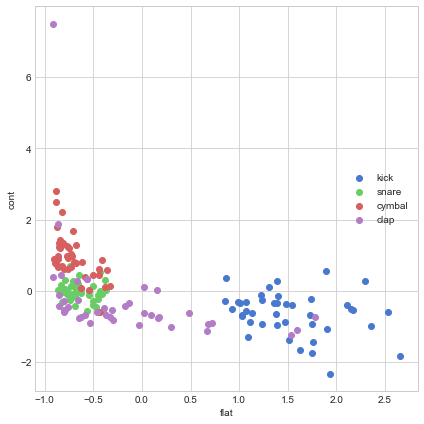

In [4]:
#Plotting the features in a 2D scatter plot
#we can plot up to 2 features (or you can attempt a 3D plot) 
#we also include an histrogram (different view of the same data)

#create a dictionary of features so that we can toggle between indexes and labels for each individual feature
feature_dict = {'zcr':0,
                'cent':1,
                'cont':2,
                'flat':3,
                'band':4,
                'roll':5,
                'rms':6}

select1 = 'flat'
select2 = 'cont'

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(features[labels==lab_val, feature_dict[select1]],
                    features[labels==lab_val, feature_dict[select2]],
                    label=lab_name
                    )
    plt.xlabel(select1)
    plt.ylabel(select2)
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.show()

### 1. Creating, learning, applying and displaying the Principal Component Analysis

(167, 7)
(167, 7)


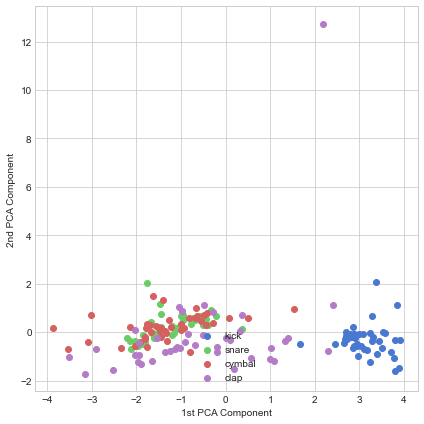

In [5]:
#Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
pca = sklearn.decomposition.PCA()

#This will learn PCA projection from data, mind that we are using the features only
pca.fit(features)

#Now we project the data into a from a 7D to a new 7D space (the principal components)
projected_features = pca.transform(features)

#the dimensionality should be the same as the feature
print(features.shape)
print(projected_features.shape)

#Plot the distribution of the data according to the first two PCA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st PCA Component')
    plt.ylabel('2nd PCA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [6]:
# most scikitlearn dimensionality reduction techniques object
# include the attribute "explained_variance_ratio_" 
# which shows the ratio (%) of variance carried by each component
# components are ranked along the columns from the most to the last "varying"

print(pca.explained_variance_ratio_)

# if we want to move forward only with a number of components 
# carrying only 95% of the total variance (i.e. information)
# we can compute the sumulative sum of the "explained_variance_ratio_"
print(np.cumsum(pca.explained_variance_ratio_))

# if you do not want to visually inspect the result, you cann get it computationally by
num_of_dim95 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)) + 1

print(num_of_dim95)

[6.08899613e-01 2.06206598e-01 9.19032253e-02 6.91365615e-02
 2.12489021e-02 2.13188839e-03 4.73211878e-04]
[0.60889961 0.81510621 0.90700944 0.976146   0.9973949  0.99952679
 1.        ]
4


### 2. Creating, learning, applying and displaying the Linear Discriminant Analysis

(167, 7)
(167, 3)


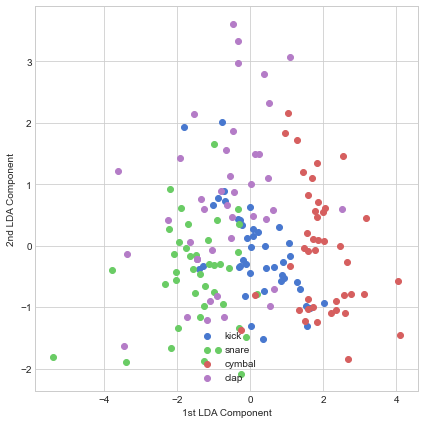

In [7]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()


#LDA needs BOTH features and labels (as integer numbers), other techniques needs only features
lda.fit(features, labels)

#Now we project the data into a from a 7D to a (number of classes - 1) space,
#if the number of components in scikit-learn, LDA transform the data to a number of dimensions
#equal to min(n_classes - 1), which in our case is 4 classes -1 = 3.
#with more classess we will have more dimensions at the output of LDA projection
projected_features = lda.transform(features)

#the dimensionality should be the same number of classes - 1
print(features.shape)
print(projected_features.shape)

#Plot the distribution of the data according to the first two LDA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 1],
                    projected_features[labels==lab_val, 2],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

### 3. Creating, learning, applying and displaying the Isomap Manifold Learning

(167, 7)
(167, 7)


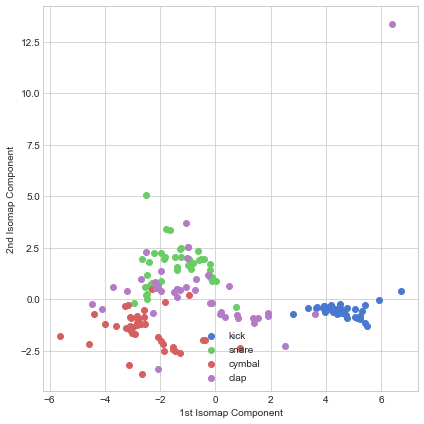

In [8]:
#Creating an instance of a Isomap object, which is an object capable of learning and applying Isomap from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
#by default isomap returns only 2 components, with the following code we force
#isomap to returnn as many components as in the input feature matrix
isomap = sklearn.manifold.Isomap(n_components=features.shape[1])

#This will learn Isomap projection from data, mind that we are using the features only
isomap.fit(features)

#Now we project the data into a from a high to a low dimensional space
projected_features = isomap.transform(features)

#the dimensionality should be the same as the feature
print(features.shape)
print(projected_features.shape)

#Plot the distribution of the data according to the first two Isomap components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st Isomap Component')
    plt.ylabel('2nd Isomap Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

### 4. Follou-up activity

1. Estimate how many component to keep by analyzing the variance (keep only 95% of the total variance) for LDA and Isomap. On Isomap you have to do this manually analyzing the variance of individual columns on the feature matrix (after Isomap projection).

2. Try with other dimensionality reduction techniques belonging to the family of [decomposition techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis), [manifold learning techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold), or [discriminant analysis techniques](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis.

3. Use the 3D scatter plot for a better visual analysis (you can visualize the first three components at least).